In [143]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [144]:
#Re-import as per "Read amplicons and summaries.ipynb"

#Import the data and flip into a multi index 
df = pd.read_csv('../Data/allele_counts.tsv', header = [0,1,2], index_col = 0, sep='\t')
df = df.stack([0,1,2])
df = df.reorder_levels([1,0,2,3])
df = df.to_frame()  #puts everything back in a dataframe
df.columns = ['Reads']
df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
df['Well'] = df.index.get_level_values(1)
df['Amplicon'] = df.index.get_level_values(2)
df['Genotype'] = df.index.get_level_values(3)
df[['Patient', 'one', 'two']] = df['Amplicon'].str.split('_', expand = True)
df = df.drop(columns = ['one', 'two'])

#Import information about plate cell type and patient
key = pd.read_excel('../Data/Amplicon_metadata_fixed.xlsx', sheet_name = 'PlateID')
key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells', 'fcs-fle' ], axis=1)
key.rename(columns = {'Comments2':'Plate'}, inplace = True)
key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)

#Make a dictionary to associate plates with patients and plate with cell type
plate_pt_dict = dict(zip(key.Plate, key.Patient))
plate_cell_dict = dict(zip(key.Plate, key.Celltype))

#Set up some lists for iteration
patients = ['RN', 'EL', 'GR']
plates = df['Plate'].drop_duplicates().to_list()
amplicons = df['Amplicon'].drop_duplicates().to_list()
genos = df['Genotype'].drop_duplicates().to_list()
wells = df['Well'].drop_duplicates().to_list()

In [145]:
#Now just look at RN data, and apply filters to identify cells with enough reads/amplicon
RN_allele_plate = df.loc[df['Patient'].isin(['RN'])] #Make df with just RN data
RN_allele_plate = RN_allele_plate.drop(columns = 'Patient') #Drop the Patient ID column and other unwanted cols

#Find the cells/wells that contain >100 reads for the selected amplicons and turn into a list 
#Re-arrange the table
df2 = RN_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum()
df2 = df2.unstack()
df2 = df2.iloc[:, 0:4] #Just keep the columns of interest
df2 = df2.loc[(df2 >= 100).all(axis=1)] #df2 contains just the rows with cells we want - use this to create a filter or key
df2 = df2.stack()

#Make the plate and well info a single column and put in a list
df2['Plate'] = df2.index.get_level_values(0)  #These lines send indexes to columns
df2['Well'] = df2.index.get_level_values(1)
df2['Plate_Well'] = df2['Plate'].astype(str) + '_' + df2['Well'].astype(str)
RN_wells = df2['Plate_Well'].to_list() #RN_wells is the list of wells that fulfill the desired criteria

#Make a file with the allele counts per well for all wells
df3 = RN_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum()
df3 = df3.unstack(2)
df3['Plate'] = df3.index.get_level_values(0)
df3['Cell_type'] = df3['Plate'].replace(plate_cell_dict)
df3.to_csv('../Results/Amp_counts/RN_all_cells_reads_per_amplicon.tsv',  sep = '\t')

In [146]:
#Extract data just for the desired cells/wells
RN_allele_plate['Plate_Well'] = RN_allele_plate['Plate'].astype(str) + '_' + RN_allele_plate['Well'].astype(str)
RN_allele_plate = RN_allele_plate[RN_allele_plate['Plate_Well'].isin(RN_wells)] #keep the wells identified before
RN_allele_plate = RN_allele_plate[RN_allele_plate['Amplicon'].isin(['RN_RUNX1_c', 'RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a'] )] #keep the amplicons that worked

#Calculates the allele frequency and saves the output into a .csv file
RN_allele_plate = RN_allele_plate.iloc[:, 0:1].unstack(level = 3)
RN_allele_plate['Total'] = RN_allele_plate.iloc[: , 0] + RN_allele_plate.iloc[: , 1]
RN_allele_plate['Mut_freq'] = RN_allele_plate.iloc[:, 0]/RN_allele_plate['Total']
RN_allele_plate.to_csv('../Results/Geno_counts/geno_counts_frequencies_raw_reads.tsv', index = None, sep = '\t')

#Convert into easily plottable format and save the output to a .csv file
RN_allele_plate = RN_allele_plate.drop(columns = ['Reads', 'Total'])
RN_allele_plate['Plate'] = RN_allele_plate.index.get_level_values(0)
RN_allele_plate['Amplicon'] = RN_allele_plate.index.get_level_values(2)
RN_allele_plate['Cell_type'] = RN_allele_plate['Plate'].replace(plate_cell_dict)
RN_allele_plate['Well'] = RN_allele_plate.index.get_level_values(1)
RN_allele_plate['Plate_Well'] = RN_allele_plate['Plate'].astype(str) + '_' + RN_allele_plate['Well'].astype(str)
RN_allele_plate.to_csv('../Results/Geno_counts/geno_counts_frequencies.tsv', index = None, sep = '\t')
 
#Make a list of cell types
#Note there are no neutrophils because the RUNX1_c amplicon isn't great (probably not expressed)
celltypes = RN_allele_plate['Cell_type'].drop_duplicates().to_list()

In [147]:
#Make lists of possible haplotypes
#possible haplotypes for 3 genotype system
first = ['Rw', 'Rh', 'RH']
second = ['_Sw', '_Sh', '_SH']
third = ['_Tw', '_Th', '_TH']
hap3 =[]

for a in first:
    for b in second:
        for c in third:
            hap3.append(a+b+c)
    
#possible haplotype for 2 genotype system
firsta = ['Rw', 'Rm']
seconda = ['_Sw', '_Sm']
thirda = ['_Tw', '_Tm']
hap2 =[]

for a in firsta:
    for b in seconda:
        for c in thirda:
            hap2.append(a+b+c)

In [148]:
#Assign three arbitrary genotypes - WT, het, hom
geno_assign3 = RN_allele_plate
conditions = [(geno_assign3['Mut_freq'] <= 0.25), (geno_assign3['Mut_freq'] > 0.25) & (geno_assign3['Mut_freq'] < 0.75), (geno_assign3['Mut_freq']) >= 0.75 ]
values = ['w', 'h', 'H']
geno_assign3['Genotype'] = np.select(conditions, values)
values3 = [0,1,2] #include a numerical score for number of mutations
geno_assign3['Order'] = np.select(conditions, values3)
geno_assign3 = geno_assign3.unstack(2)
geno_assign3 = geno_assign3.drop(columns = ['Mut_freq', 'Plate',  'Cell_type', 'Well', 'Plate_Well']) #drop unwanted columns

#Rearrange df
geno_assign3 = geno_assign3.stack()
geno_assign3 = geno_assign3.loc[geno_assign3['Amplicon'].isin(['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a'])]  #drop RUNX1 cDNA for simplicity
geno_assign3 = geno_assign3.drop(columns = ['Amplicon'])
geno_assign3 = geno_assign3.unstack()
geno_assign3['Mut_score'] = geno_assign3.iloc[:, 3:6].sum(axis = 1)  #add the mutation scores together
geno_assign3 = geno_assign3.drop(columns = ['Order'])
geno_assign3.columns = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a', 'Mut_score'] #renaming as something went funny in previous steps

geno_assign3['haplotype'] = 'R' + geno_assign3['RN_RUNX1_g'] + '_S' + geno_assign3['RN_SRSF2'] + '_T' + geno_assign3['RN_TET2a']
haps = geno_assign3['haplotype'].drop_duplicates().to_list()
geno_assign3['Cell_type'] = geno_assign3.index.get_level_values(0)
geno_assign3 = geno_assign3.replace({'Cell_type': plate_cell_dict})
geno_assign3 = geno_assign3.drop(columns = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a'])
print('The number of haplotypes present using 3 genotypes is: ', len(haps)) # haplotypes (3 arbitrary classes, WT (W), heterozygote (h), homozygote (H))

The number of haplotypes present using 3 genotypes is:  17


In [149]:
#Plot three haplotype data
fig, axes = plt.subplots(2,2, figsize = (16,8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = axes.ravel()
count = -1

for cell in celltypes:
    count += 1
    ax[count] = geno_assign3.loc[geno_assign3['Cell_type'].isin([cell])]['haplotype'].value_counts().plot(kind = 'bar', ax = ax[count])
    ax[count].set_title(str(cell)) 
    ax[count].set_ylabel('Number of cells')
    
fig.suptitle('3 haplotype count by cell type', fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype3_freq_cellype.png',dpi=300)     
plt.close() #Plot just goes to file and isn't displayed    

In [150]:
#Plot three haplotype data - by number of mutations
fig, axes = plt.subplots(2,2, figsize = (16,8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = axes.ravel()
count = -1

for cell in celltypes:
    count += 1
    ax[count] = geno_assign3.loc[geno_assign3['Cell_type'].isin([cell])]['Mut_score'].value_counts().plot(kind = 'bar', ax = ax[count])
    ax[count].set_title(str(cell)) 
    ax[count].set_xlabel('Number of mutated alleles')
    ax[count].set_ylabel('Number of cells')
    
fig.suptitle('3 haplotype mutant allele count by cell type', fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype3_mut_allele_freq_celltype.png',dpi=300)     
plt.close() #Plot just goes to file and isn't displayed  

In [151]:
#Assign two arbitrary genotypes - WT or MT  ***
geno_assign2 = RN_allele_plate
cutoff = 0.25
conditions = [(geno_assign2['Mut_freq'] <= cutoff), (geno_assign2['Mut_freq']) > cutoff ]
values = ['w', 'm']
geno_assign2['Genotype'] = np.select(conditions, values)
values2 = [0,1] #include a numerical score for number of mutations
geno_assign2['Order'] = np.select(conditions, values2)
geno_assign2 = geno_assign2.unstack(2)

geno_assign2 = geno_assign2.drop(columns = ['Mut_freq', 'Plate',  'Cell_type', 'Well', 'Plate_Well']) #drop unwanted columns

#Rearrange df
geno_assign2 = geno_assign2.stack()
geno_assign2 = geno_assign2.loc[geno_assign2['Amplicon'].isin(['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a'])]  #drop RUNX1 cDNA for simplicity
geno_assign2 = geno_assign2.drop(columns = ['Amplicon'])
geno_assign2 = geno_assign2.unstack()
geno_assign2['Mut_score'] = geno_assign2.iloc[:, 3:6].sum(axis = 1)  #add the mutation scores together
geno_assign2 = geno_assign2.drop(columns = ['Order'])
geno_assign2.columns = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a', 'Mut_score'] #renaming as something went funny in previous steps

geno_assign2['haplotype'] = 'R' + geno_assign2['RN_RUNX1_g'] + '_S' + geno_assign2['RN_SRSF2'] + '_T' + geno_assign2['RN_TET2a']
haps2 = geno_assign2['haplotype'].drop_duplicates().to_list()
geno_assign2['Cell_type'] = geno_assign2.index.get_level_values(0)
geno_assign2 = geno_assign2.replace({"Cell_type": plate_cell_dict})
geno_assign2 = geno_assign2.drop(columns = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a'])
simple2 = ['RST', 'RSt', 'RsT', 'Rst', 'rST', 'rSt','rsT', 'rst'] #make simpler labels
hap2_simple = dict(zip(hap2, simple2))
hap2_simple
geno_assign2['hap'] = geno_assign2['haplotype'].replace(hap2_simple)
print('The number of haplotypes present using 2 genotypes is: ', len(haps2)) # haplotypes (3 arbitrary classes, WT (W), heterozygote (h), homozygote (H))

The number of haplotypes present using 2 genotypes is:  6


In [152]:
#Plot two haplotype data
fig, axes = plt.subplots(2,2, figsize = (16,8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = axes.ravel()
count = -1

for cell in celltypes:
    count += 1
    ax[count] = geno_assign2.loc[geno_assign2['Cell_type'].isin([cell])]['hap'].value_counts().plot(kind = 'bar', ax = ax[count])
    ax[count].set_title(str(cell)) 
    ax[count].set_ylabel('Number of cells')
    
fig.suptitle('2 haplotype count by cell type', fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype2_freq_celltype.png',dpi=300)     
plt.close() #Plot just goes to file and isn't displayed   

In [153]:
#Plot two haplotype data - by number of mutations
fig, axes = plt.subplots(2,2, figsize = (16,8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = axes.ravel()
count = -1

for cell in celltypes:
    count += 1
    ax[count] = geno_assign2.loc[geno_assign2['Cell_type'].isin([cell])]['Mut_score'].value_counts().plot(kind = 'bar', ax = ax[count])
    ax[count].set_title(str(cell)) 
    ax[count].set_xlabel('Number of mutated alleles')
    ax[count].set_ylabel('Number of cells')
    
fig.suptitle('2 haplotype mutant allele count by cell type', fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype2_mut_allele_freq_celltype.png',dpi=300)     
plt.close() #Plot just goes to file and isn't displayed   

In [154]:
#Colour for specific haplotypes - works, but can't figure out how to apply using df.plot May need to convert RGB numbers
#Make colour lists
col8 = sns.color_palette("husl", 8)
col27 = sns.color_palette("husl", 27)

test = dict(zip(simple2, col8))

In [155]:
#Plot two haplotype data - second method to add colour for each haplotype
fig, axes = plt.subplots(2,2, figsize = (16,8))
fig.subplots_adjust(hspace = 0.5, wspace=.3)
ax = axes.ravel()
count = -1

for cell in celltypes:
    count += 1
    
    a = geno_assign2.loc[geno_assign2['Cell_type'].isin([cell])]['hap'].value_counts().rename_axis('hap').reset_index(name='counts')
    b = a['counts'].sum()
    a['proportion'] = a['counts']/b
    
    ax[count] = sns.barplot(x='hap', y='proportion', data = a, palette = test, ax = ax[count]) #fro scatter add  hue = 'hap'
    ax[count].set_title(str(cell)) 
    ax[count].set_ylabel('Number of cells', fontsize = 14)
    ax[count].set_xlabel('Haplotype', fontsize = 14)
    ax[count].set_ylim(0.001,0.999)
    #ax[count].set_yscale('logit') #use this only with scatterplot
    
fig.suptitle('2 haplotype count by cell type', fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype2_freq_celltype_colour.png',dpi=300)     
plt.close() #Plot just goes to file and isn't displayed   

In [156]:
RN_allele_plate

Mut_freq   Plate    Amplicon  Cell_type Well  \
                                                                      
AS-194 A13 RN_RUNX1_c  0.000000  AS-194  RN_RUNX1_c       nBCs  A13   
           RN_RUNX1_g  0.000384  AS-194  RN_RUNX1_g       nBCs  A13   
           RN_SRSF2    0.010638  AS-194    RN_SRSF2       nBCs  A13   
           RN_TET2a    0.000000  AS-194    RN_TET2a       nBCs  A13   
       B13 RN_RUNX1_c  0.005865  AS-194  RN_RUNX1_c       nBCs  B13   
...                         ...     ...         ...        ...  ...   
AS-193 O12 RN_TET2a    0.453782  AS-193    RN_TET2a  Monocytes  O12   
       O20 RN_RUNX1_c  0.033149  AS-193  RN_RUNX1_c  Monocytes  O20   
           RN_RUNX1_g  0.001278  AS-193  RN_RUNX1_g  Monocytes  O20   
           RN_SRSF2    0.113208  AS-193    RN_SRSF2  Monocytes  O20   
           RN_TET2a    0.155172  AS-193    RN_TET2a  Monocytes  O20   

                       Plate_Well Genotype Order  
                                                  
AS-194 A13 RN_RUNX1_c  AS-194_A13        w     0  
           RN_RUNX1_g  AS-194_A13        w     0  
           RN_SRSF2    AS-194_A13        w     0  
           RN_TET2a    AS-194_A13        w     0  
       B13 RN_RUNX1_c  AS-194_B13        w     0  
...                           ...      ...   ...  
AS-193 O12 RN_TET2a    AS-193_O12        m     1  
       O20 RN_RUNX1_c  AS-193_O20        w     0  
           RN_RUNX1_g  AS-193_O20        w     0  
           RN_SRSF2    AS-193_O20        w     0  
           RN_TET2a    AS-193_O20        w     0  

[3024 rows x 8 columns]

In [350]:
#Trialling looking at a few more cells - first recreate allele plate df ()
RN_allele_plate2 = df.loc[df['Patient'].isin(['RN'])] #Make df with just RN data
RN_allele_plate2 = RN_allele_plate2.drop(columns = 'Patient') #Drop the Patient ID column and other unwanted cols
RN_allele_plate_4gen = RN_allele_plate2.groupby(['Plate', 'Well', 'Amplicon']).sum()
RN_allele_plate_4gen = RN_allele_plate_4gen.unstack()

#Now just keep gDNA amplicons
RN_allele_plate_4gen = RN_allele_plate_4gen.iloc[:, [1,2,3,5]] #Just keep the columns of interest
RN_allele_plate_4gen = RN_allele_plate_4gen.loc[(RN_allele_plate_4gen >= 15).all(axis=1)] #RN_allele_plate_4gen contains just the rows with cells we want - use this to create a filter or key
#Number of cells at various cutoffs - 100 - 17 cells, 75 - 22 cells, 50 - 32 cells, 25 - 77 cells, 15 - 162 cells, 10 - 253 cells
RN_allele_plate_4gen = RN_allele_plate_4gen.stack()
RN_allele_plate_4genL = RN_allele_plate_4gen
#Make the plate and well info a single column and put in a list
RN_allele_plate_4genL['Plate'] = RN_allele_plate_4genL.index.get_level_values(0)  #These lines send indexes to columns
RN_allele_plate_4genL['Well'] = RN_allele_plate_4genL.index.get_level_values(1)
RN_allele_plate_4genL['Plate_Well'] = RN_allele_plate_4genL['Plate'].astype(str) + '_' + RN_allele_plate_4genL['Well'].astype(str)
RN_wells_4gen_15 = RN_allele_plate_4genL['Plate_Well'].to_list() #RN_wells is the list of wells that fulfill the desired criteria

#Extract data just for the desired cells/wells
RN_allele_plate2['Plate_Well'] = RN_allele_plate2['Plate'].astype(str) + '_' + RN_allele_plate2['Well'].astype(str)
RN_allele_plate2 = RN_allele_plate2[RN_allele_plate2['Plate_Well'].isin(RN_wells_4gen_15)] #keep the wells identified before
RN_allele_plate2 = RN_allele_plate2[RN_allele_plate2['Amplicon'].isin(['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a', 'RN_TET2b_g'] )] #keep the amplicons that worked

#Calculates the allele frequency
RN_allele_plate2 = RN_allele_plate2.iloc[:, 0:1].unstack(level = 3)
RN_allele_plate2['Total'] = RN_allele_plate2.iloc[: , 0] + RN_allele_plate2.iloc[: , 1]
RN_allele_plate2['Mut_freq'] = RN_allele_plate2.iloc[:, 0]/RN_allele_plate2['Total']

#Convert into easily plottable format
RN_allele_plate2 = RN_allele_plate2.drop(columns = ['Reads', 'Total'])
RN_allele_plate2['Plate'] = RN_allele_plate2.index.get_level_values(0)
RN_allele_plate2['Amplicon'] = RN_allele_plate2.index.get_level_values(2)
RN_allele_plate2['Cell_type'] = RN_allele_plate2['Plate'].replace(plate_cell_dict)
RN_allele_plate2['Well'] = RN_allele_plate2.index.get_level_values(1)
RN_allele_plate2['Plate_Well'] = RN_allele_plate2['Plate'].astype(str) + '_' + RN_allele_plate2['Well'].astype(str)

 
#Make a list of cell types
#All cell types are represented now
celltypes2 = RN_allele_plate2['Cell_type'].drop_duplicates().to_list()
#celltypes2
#RN_allele_plate2

In [351]:
#Assign two arbitrary genotypes - WT or MT with desired cutoff
geno_assign2b = RN_allele_plate2
cutoff = 0.1 #cutoff for haplotype definition
conditions = [(geno_assign2b['Mut_freq'] <= cutoff), (geno_assign2b['Mut_freq']) > cutoff ] #can tweak cutoff here
values = ['w', 'm']
geno_assign2b['Genotype'] = np.select(conditions, values)
values2 = [0,1] #include a numerical score for number of mutations
geno_assign2b['Order'] = np.select(conditions, values2)
geno_assign2b = geno_assign2b.unstack(2)

geno_assign2b = geno_assign2b.drop(columns = ['Mut_freq', 'Plate',  'Cell_type', 'Well', 'Plate_Well']) #drop unwanted columns

#Rearrange df
geno_assign2b = geno_assign2b.stack()
geno_assign2b = geno_assign2b.drop(columns = ['Amplicon'])
geno_assign2b = geno_assign2b.unstack()
geno_assign2b['Mut_score'] = geno_assign2b.iloc[:, 4:7].sum(axis = 1)  #add the mutation scores together
geno_assign2b = geno_assign2b.drop(columns = ['Order'])
geno_assign2b.columns = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a','RN_TET2b', 'Mut_score'] #renaming as something went funny in previous steps
geno_assign2b['Rhap'] = 'R' + geno_assign2b['RN_RUNX1_g'] #Make new column with mutation status for each gene
geno_assign2b['Shap'] = 'S' + geno_assign2b['RN_SRSF2']
geno_assign2b['Ahap'] = 'A' + geno_assign2b['RN_TET2a']
geno_assign2b['Bhap'] = 'B' + geno_assign2b['RN_TET2b']

#Make haplotype swap dictionary and change haplotypes
hap_assign1 = ['Rw', 'Rm', 'Sw', 'Sm', 'Aw', 'Am', 'Bw', 'Bm']
hap_assign2 = ['R', 'r', 'S', 's', 'A', 'a', 'B', 'b']
hap_assign = dict(zip(hap_assign1, hap_assign2))
geno_assign2b = geno_assign2b.replace({'Shap': hap_assign}).replace({'Rhap': hap_assign}).replace({'Ahap': hap_assign}).replace({'Bhap': hap_assign})
geno_assign2b['hap'] = geno_assign2b['Shap'] +  geno_assign2b['Ahap'] + geno_assign2b['Bhap'] +  geno_assign2b['Rhap']
haps2b = geno_assign2b['hap'].drop_duplicates().to_list()
geno_assign2b['Cell_type'] = geno_assign2b.index.get_level_values(0)
geno_assign2b = geno_assign2b.replace({"Cell_type": plate_cell_dict})
geno_assign2b = geno_assign2b.drop(columns = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a', 'RN_TET2b'])
#print('The number of haplotypes present using 2 genotypes with a ', cutoff, ' cutoff is: ', len(haps2b))
geno_assign2b
#haps2b
#hap_assign

Mut_score Rhap Shap Ahap Bhap   hap Cell_type
AS-195 B4           2    R    s    a    b  sabR       NEs
       B9           2    R    s    a    B  saBR       NEs
       B12          2    R    s    a    b  sabR       NEs
       B18          2    R    s    a    b  sabR       NEs
       C9           2    R    s    a    B  saBR       NEs
...               ...  ...  ...  ...  ...   ...       ...
AS-194 O18          0    R    S    A    B  SABR      nBCs
       O20          0    R    S    A    B  SABR      nBCs
       O22          0    R    S    A    B  SABR      nBCs
AS-197 K21          2    R    s    a    B  saBR      CD34
       L2           2    R    s    a    b  sabR      CD34

[162 rows x 7 columns]

In [352]:
#Make a colour palette with a colour for each haplotype
num_cols = len(haps2b)
cols = sns.color_palette("husl", num_cols)
test2b = dict(zip(haps2b, cols))

In [353]:
#Trying to plot in order from least to most mutated
#possible haplotype for 2 genotype system
firsta = ['S', 's']
seconda = ['A', 'a']
thirda = ['B', 'b']
fourtha = ['R', 'r']
hap2b_poss =[]

for a in firsta:
    for b in seconda:
        for c in thirda:
            for d in fourtha:
                hap2b_poss.append(a+b+c+d)
                
order = [0, 4, 3, 10, 2, 9, 8, 14, 1, 7, 6, 12, 5, 13, 11, 15]
hap2b_order = dict(zip(hap2b_poss, order))
hap2b_order

{'SABR': 0,
 'SABr': 4,
 'SAbR': 3,
 'SAbr': 10,
 'SaBR': 2,
 'SaBr': 9,
 'SabR': 8,
 'Sabr': 14,
 'sABR': 1,
 'sABr': 7,
 'sAbR': 6,
 'sAbr': 12,
 'saBR': 5,
 'saBr': 13,
 'sabR': 11,
 'sabr': 15}

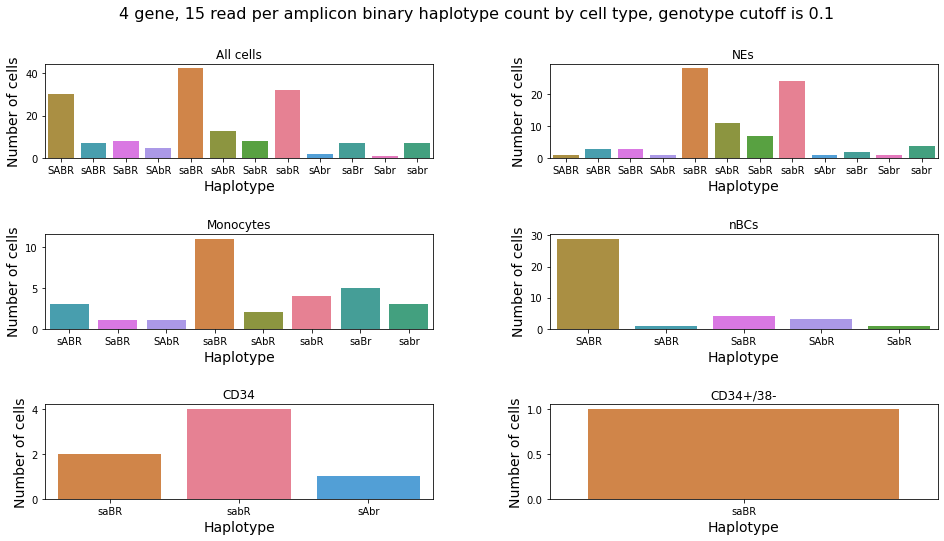

In [354]:
#Plot two haplotype data for 4 gene 15 amplicon set - second method to add colour for each haplotype
fig, axes = plt.subplots(3,2, figsize = (16,8))
fig.subplots_adjust(hspace = 0.8, wspace=.3)
ax = axes.ravel()
count = 0

c = geno_assign2b['hap'].value_counts().rename_axis('hap').reset_index(name='counts')
c['order'] = c['hap']
c = c.replace({'order': hap2b_order})
c = c.sort_values(by=['order'])
d = c['counts'].sum()
c['proportion'] = c['counts']/d

ax[0] = sns.barplot(x='hap', y='counts', data = c, palette = test2b, ax = ax[count]) #fro scatter add  hue = 'hap'
ax[0].set_title('All cells') 
ax[0].set_ylabel('Number of cells', fontsize = 14)
ax[0].set_xlabel('Haplotype', fontsize = 14)
#ax[0].set_ylim(0.001,0.999)
#ax[count].set_yscale('logit') #use this only with scatterplot

for cell in celltypes2:
    count += 1
    
    a = geno_assign2b.loc[geno_assign2b['Cell_type'].isin([cell])]['hap'].value_counts().rename_axis('hap').reset_index(name='counts')
    a['order'] = a['hap']
    a = a.replace({'order': hap2b_order})
    a = a.sort_values(by=['order'])
    b = a['counts'].sum()
    a['proportion'] = a['counts']/b
    
    ax[count] = sns.barplot(x='hap', y='counts', data = a, palette = test2b, ax = ax[count]) #for scatter add  hue = 'hap'
    ax[count].set_title(str(cell)) 
    ax[count].set_ylabel('Number of cells', fontsize = 14)
    ax[count].set_xlabel('Haplotype', fontsize = 14)
    #ax[count].set_ylim(0.001,0.999)
    #ax[count].set_yscale('logit') #use this only with scatterplot
    
fig.suptitle('4 gene, 15 read per amplicon binary haplotype count by cell type, genotype cutoff is ' + str(cutoff), fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype2_freq_celltype_colour_4gen_15amp.png',dpi=300)     
#plt.close() #Plot just goes to file and isn't displayed   

In [239]:
geno_assign2b.to_csv('../Results/Haplotypes/RN_4gen_15reads_per_amplicon.tsv',  sep = '\t')

In [332]:
#Assign two arbitrary genotypes - WT or MT - recoded for auto haplotype counting
geno_assign2 = RN_allele_plate
gen3cutoff = 0.1
conditions = [(geno_assign2['Mut_freq'] <= gen3cutoff), (geno_assign2['Mut_freq']) > gen3cutoff ]
values = ['w', 'm']
geno_assign2['Genotype'] = np.select(conditions, values)
values2 = [0,1] #include a numerical score for number of mutations
geno_assign2['Order'] = np.select(conditions, values2)
geno_assign2 = geno_assign2.unstack(2)

geno_assign2 = geno_assign2.drop(columns = ['Mut_freq', 'Plate',  'Cell_type', 'Well', 'Plate_Well']) #drop unwanted columns

#Rearrange df
geno_assign2 = geno_assign2.stack()
geno_assign2 = geno_assign2.loc[geno_assign2['Amplicon'].isin(['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a'])]  #drop RUNX1 cDNA for simplicity
geno_assign2 = geno_assign2.drop(columns = ['Amplicon'])
geno_assign2 = geno_assign2.unstack()
geno_assign2['Mut_score'] = geno_assign2.iloc[:, 3:6].sum(axis = 1)  #add the mutation scores together
geno_assign2 = geno_assign2.drop(columns = ['Order'])
geno_assign2.columns = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a', 'Mut_score'] #renaming as something went funny in previous steps



geno_assign2['Rhap'] = 'R' + geno_assign2['RN_RUNX1_g'] #Make new column with mutation status for each gene
geno_assign2['Shap'] = 'S' + geno_assign2['RN_SRSF2']
geno_assign2['Ahap'] = 'A' + geno_assign2['RN_TET2a']

#Make haplotype swap dictionary and change haplotypes
hap_assign1 = ['Rw', 'Rm', 'Sw', 'Sm', 'Aw', 'Am']
hap_assign2 = ['R', 'r', 'S', 's', 'A', 'a']
hap_assign = dict(zip(hap_assign1, hap_assign2))
geno_assign2 = geno_assign2.replace({'Shap': hap_assign}).replace({'Rhap': hap_assign}).replace({'Ahap': hap_assign})
geno_assign2['hap'] = geno_assign2['Shap'] +  geno_assign2['Ahap'] +  geno_assign2['Rhap']
haps2 = geno_assign2['hap'].drop_duplicates().to_list()
geno_assign2['Cell_type'] = geno_assign2.index.get_level_values(0)
geno_assign2 = geno_assign2.replace({"Cell_type": plate_cell_dict})
geno_assign2 = geno_assign2.drop(columns = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a'])

print('The number of haplotypes present using 2 genotypes with a ', gen3cutoff, ' cutoff is: ', len(haps2))

The number of haplotypes present using 2 genotypes with a  0.1  cutoff is:  8


In [329]:
#Make a colour palette with a colour for each haplotype
num_cols = len(haps2)
cols = sns.color_palette("husl", num_cols)
test2 = dict(zip(haps2, cols))
test2

{'SAR': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 'SaR': (0.8087954113106306, 0.5634700050056693, 0.19502642696727285),
 'sAR': (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 'saR': (0.19783576093349015, 0.6955516966063037, 0.3995301037444499),
 'sar': (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 'sAr': (0.22335772267769388, 0.6565792317435265, 0.8171355503265633),
 'SAr': (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 'Sar': (0.9603888539940703, 0.3814317878772117, 0.8683117650835491)}

In [330]:
#Trying to plot in order from least to most mutated
#possible haplotype for 2 genotype system
firsta = ['S', 's']
seconda = ['A', 'a']
fourtha = ['R', 'r']
hap2_poss =[]

for a in firsta:
    for b in seconda:
        for d in fourtha:
            hap2_poss.append(a+b+d)
                
order = [0, 3, 2, 6, 1, 5, 4, 7]
hap2_order = dict(zip(hap2_poss, order))
hap2_order

{'SAR': 0,
 'SAr': 3,
 'SaR': 2,
 'Sar': 6,
 'sAR': 1,
 'sAr': 5,
 'saR': 4,
 'sar': 7}

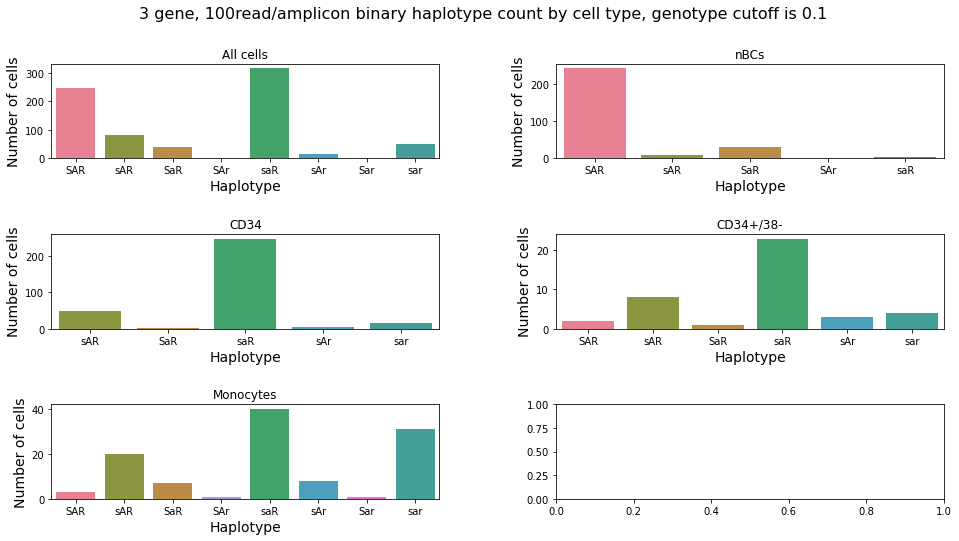

In [342]:
#Plot two haplotype data for 3 gene 100 amplicon set - second method to add colour for each haplotype
fig, axes = plt.subplots(3,2, figsize = (16,8))
fig.subplots_adjust(hspace = 0.8, wspace=.3)
ax = axes.ravel()
count = 0

c = geno_assign2['hap'].value_counts().rename_axis('hap').reset_index(name='counts')
c['order'] = c['hap']
c = c.replace({'order': hap2_order})
c = c.sort_values(by=['order'])
d = c['counts'].sum()
c['proportion'] = c['counts']/d

ax[0] = sns.barplot(x='hap', y='counts', data = c, palette = test2, ax = ax[count]) #fro scatter add  hue = 'hap'
ax[0].set_title('All cells') 
ax[0].set_ylabel('Number of cells', fontsize = 14)
ax[0].set_xlabel('Haplotype', fontsize = 14)
#ax[0].set_ylim(0.001,0.999)
#ax[count].set_yscale('logit') #use this only with scatterplot

for cell in celltypes:
    count += 1
    
    if geno_assign2.loc[geno_assign2['Cell_type'].isin([cell])].empty ==False:
    
        a = geno_assign2.loc[geno_assign2['Cell_type'].isin([cell])]['hap'].value_counts().rename_axis('hap').reset_index(name='counts')
        a['order'] = a['hap']
        a = a.replace({'order': hap2_order})
        a = a.sort_values(by=['order'])
        b = a['counts'].sum()
        a['proportion'] = a['counts']/b
    
        ax[count] = sns.barplot(x='hap', y='counts', data = a, palette = test2, ax = ax[count]) #for scatter add  hue = 'hap'
        ax[count].set_title(str(cell)) 
        ax[count].set_ylabel('Number of cells', fontsize = 14)
        ax[count].set_xlabel('Haplotype', fontsize = 14)
        #ax[count].set_ylim(0.001,0.999)
        #ax[count].set_yscale('logit') #use this only with scatterplot
        
    else:
        continue
    
fig.suptitle('3 gene, 100read/amplicon binary haplotype count by cell type, genotype cutoff is ' + str(gen3cutoff), fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype2_freq_celltype_colour_3gen_100amp.png',dpi=300)     
#plt.close() #Plot just goes to file and isn't displayed   

In [304]:
a

,hap,counts,order,proportion
